# MSDS 7331 - Lab 1 - Baseball (Lehmans's Dataset)
***
Team - Triston Hudgins, Shijo Joseph, Douglas Yip

In [12]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

***
### Business Understanding (10 points total). Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific

The reason why we selected Lehman's baseball dataset is to understand the difficult decision a Major League Baseball (MLB) General Manager (GM) has to field a competitive team of talent while balancing that the fall below the team's salary cap.  Salary caps in baseball are placed to reduce anti-competitive behavior in the league.  This creates guardrails and fairness on how contracts are offered to players.  Teams that chose to spend more than the salary cap are penalized with "Competitive Balance Tax" (CBT).  Teams are asses a 20% tax for their first season above the salary cap and tax rate become more punitive for every consective year above the salary cap.

The performance of a player are usually rewarded contracts of varying degrees.  In this analysis, we will see how a players offensive stats can predict the outcome of player's salary.  We will categorize the salaries from Low to Elite to measure the effectives of our prediction model.

> Sources
> - http://origin.mlb.com/glossary/transactions/competitive-balance-tax
> - https://bleacherreport.com/articles/32306-open-mic-why-baseball-gms-have-the-most-difficult-job
***

##### Loading the data sets Player offensive stats and salaries.

In [3]:
# load the Lehman's baseball Batting dataset
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331_lab1/main/Batting.csv') # read in the csv file
df = df[(df['yearID'] == 2015)]
df.head()

playerID  yearID  stint teamID lgID    G   AB   R    H  2B  ...  \
99862  aardsda01    2015      1    ATL   NL   33    1   0    0   0  ...   
99863   abadfe01    2015      1    OAK   AL   62    0   0    0   0  ...   
99864  abreujo02    2015      1    CHA   AL  154  613  88  178  34  ...   
99865  achteaj01    2015      1    MIN   AL   11    0   0    0   0  ...   
99866  ackledu01    2015      1    SEA   AL   85  186  22   40   8  ...   

         RBI   SB   CS  BB     SO   IBB   HBP   SH   SF  GIDP  
99862    0.0  0.0  0.0   0    1.0   0.0   0.0  0.0  0.0   0.0  
99863    0.0  0.0  0.0   0    0.0   0.0   0.0  0.0  0.0   0.0  
99864  101.0  0.0  0.0  39  140.0  11.0  15.0  0.0  1.0  16.0  
99865    0.0  0.0  0.0   0    0.0   0.0   0.0  0.0  0.0   0.0  
99866   19.0  2.0  2.0  14   38.0   0.0   1.0  3.0  3.0   3.0  

[5 rows x 22 columns]

In [4]:
# load the Lehman's baseball salary dataset

df_salary = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331_lab1/main/Salaries.csv') # read in the csv file
df_salary = df_salary[(df_salary['yearID'] == 2015)]
df_salary.head()

yearID teamID lgID   playerID   salary
24758    2015    ARI   NL  ahmedni01   508500
24759    2015    ARI   NL  anderch01   512500
24760    2015    ARI   NL  chafian01   507500
24761    2015    ARI   NL  collmjo01  1400000
24762    2015    ARI   NL  corbipa01   524000

Merging of the data sets will help us get a better picture of a players salary and their baseball stats

In [6]:
df = pd.merge(df,df_salary[['playerID','salary']],on='playerID', how='left')
df.head()

playerID  yearID  stint teamID lgID    G   AB   R    H  2B  ...   SB   CS  \
0  aardsda01    2015      1    ATL   NL   33    1   0    0   0  ...  0.0  0.0   
1   abadfe01    2015      1    OAK   AL   62    0   0    0   0  ...  0.0  0.0   
2  abreujo02    2015      1    CHA   AL  154  613  88  178  34  ...  0.0  0.0   
3  achteaj01    2015      1    MIN   AL   11    0   0    0   0  ...  0.0  0.0   
4  ackledu01    2015      1    SEA   AL   85  186  22   40   8  ...  2.0  2.0   

   BB     SO   IBB   HBP   SH   SF  GIDP     salary  
0   0    1.0   0.0   0.0  0.0  0.0   0.0        NaN  
1   0    0.0   0.0   0.0  0.0  0.0   0.0  1087500.0  
2  39  140.0  11.0  15.0  0.0  1.0  16.0  8666000.0  
3   0    0.0   0.0   0.0  0.0  0.0   0.0        NaN  
4  14   38.0   0.0   1.0  3.0  3.0   3.0  2600000.0  

[5 rows x 23 columns]

***
### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.

In [7]:
#following code will describe the data
df.describe()

yearID        stint            G           AB            R  \
count  1486.0  1486.000000  1486.000000  1486.000000  1486.000000   
mean   2015.0     1.096904    47.465680   111.364738    13.894347   
std       0.0     0.309279    44.777758   174.890616    23.972998   
min    2015.0     1.000000     1.000000     0.000000     0.000000   
25%    2015.0     1.000000    13.000000     0.000000     0.000000   
50%    2015.0     1.000000    31.000000    12.000000     1.000000   
75%    2015.0     1.000000    68.000000   155.000000    17.000000   
max    2015.0     3.000000   162.000000   638.000000   122.000000   

                 H           2B           3B           HR          RBI  \
count  1486.000000  1486.000000  1486.000000  1486.000000  1486.000000   
mean     28.335128     5.546433     0.631898     3.303499    13.223419   
std      47.498992     9.534636     1.546506     6.866506    23.508546   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       2.000000     0.000000     0.000000     0.000000     0.000000   
75%      39.750000     7.000000     0.000000     3.000000    17.000000   
max     205.000000    45.000000    15.000000    47.000000   130.000000   

                SB           CS           BB           SO          IBB  \
count  1486.000000  1486.000000  1486.000000  1486.000000  1486.000000   
mean      1.685734     0.716016     9.470390    25.199192     0.639973   
std       4.887574     1.756596    17.470518    38.210625     1.971580   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     4.000000     0.000000   
75%       1.000000     0.000000    12.000000    36.000000     0.000000   
max      58.000000    20.000000   143.000000   208.000000    29.000000   

               HBP           SH           SF         GIDP        salary  
count  1486.000000  1486.000000  1486.000000  1486.000000  9.180000e+02  
mean      1.078062     0.807537     0.829071     2.516151  4.418232e+06  
std       2.494026     1.758281     1.730025     4.675541  5.488740e+06  
min       0.000000     0.000000     0.000000     0.000000  5.070000e+05  
25%       0.000000     0.000000     0.000000     0.000000  5.250250e+05  
50%       0.000000     0.000000     0.000000     0.000000  2.000000e+06  
75%       1.000000     1.000000     1.000000     3.000000  6.181250e+06  
max      30.000000    14.000000    11.000000    28.000000  3.257100e+07

In [8]:
print (df.dtypes)
print (df.info())

playerID     object
yearID        int64
stint         int64
teamID       object
lgID         object
G             int64
AB            int64
R             int64
H             int64
2B            int64
3B            int64
HR            int64
RBI         float64
SB          float64
CS          float64
BB            int64
SO          float64
IBB         float64
HBP         float64
SH          float64
SF          float64
GIDP        float64
salary      float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 0 to 1485
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  1486 non-null   object 
 1   yearID    1486 non-null   int64  
 2   stint     1486 non-null   int64  
 3   teamID    1486 non-null   object 
 4   lgID      1486 non-null   object 
 5   G         1486 non-null   int64  
 6   AB        1486 non-null   int64  
 7   R         1486 non-null   int64  
 8   H         1486 non-null 

#### Summary of values
A total of 1486 offsensive players were recorded in the dataset for 2015.
The following full season statistics (columns of continous variables) will be used
 - __G:__- Games played
 - __AB:__- Number of plate apearances
 - __R:__- Number of times a player scores
 - __H:__- Number of hits
 - __2B:__- Number of doubles
 - __3B:__- Number of triples
 - __HR:__- Number of home runs
 - __RBI:__- Number of Runs Batted In
 - __SB:__- Number of stolen bases 
 - __CS:__- Number of times caught stealing
 - __BB:__- Number of base on balls (walks)
 - __SO:__- Number of strike outs
 - __IBB:__- Number of intentional base on balls (walks)
 - __HBP:__- Number of times hit by pitch
 - __SH:__- Number of sacrifice hits.  Recorded when player is able to advance the runner
 - __SB:__- Number of sacrifice bunts.  Recorded when player is able to advance the runner
 - __SF:__- Number of sacrifice fly.  Recorded when player is able to advance the runner and run scores
 - __GIDP:__- Number of Grounded in Double Play.  Recorded when player inability to hit that results into two outs.
 - __Salary:__- Players earnings in the season
 
 Categorical Varialbes definition butwill not be used in analysis
 - __playerID:__- Unique Identifier of player
 - __teamID:__- Unique Identifier of team
 - __lgID:__- Unique Identifier which league they play in

In [9]:
display(df.shape)

(1486, 23)

The dataset has 1486 rows and 23 columns

***
### [15 points] Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Be specific.

In [10]:
#check for NA
df.isnull().sum()

playerID      0
yearID        0
stint         0
teamID        0
lgID          0
G             0
AB            0
R             0
H             0
2B            0
3B            0
HR            0
RBI           0
SB            0
CS            0
BB            0
SO            0
IBB           0
HBP           0
SH            0
SF            0
GIDP          0
salary      568
dtype: int64

In [27]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,1)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = nan_df.append(complete_df, sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 template='plotly_dark',
                 opacity = 0.6,
                 color_discrete_sequence=['#dbdbdb','#38cae0'],
                 width=800,
                 height=400)
    fig.show()

plot_missingness(df)

We want to see what type of players don't have salary details.

playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...   SB  \
0     aardsda01    2015      1    ATL   NL  33    1   0   0   0  ...  0.0   
3     achteaj01    2015      1    MIN   AL  11    0   0   0   0  ...  0.0   
6     adamecr01    2015      1    COL   NL  26   53   4  13   1  ...  0.0   
9     adcocna01    2015      1    CIN   NL  13    0   0   0   0  ...  0.0   
10    adriaeh01    2015      1    SFN   NL  52  113  11  21   7  ...  3.0   
...         ...     ...    ...    ...  ...  ..  ...  ..  ..  ..  ...  ...   
1458   wolfra02    2015      1    DET   AL   8    0   0   0   0  ...  0.0   
1466  wrighmi01    2015      1    BAL   AL  12    2   0   1   0  ...  0.0   
1472   ynoara01    2015      1    COL   NL  72  127  14  33   8  ...  1.0   
1481   zitoba01    2015      1    OAK   AL   3    0   0   0   0  ...  0.0   
1485   zychto01    2015      1    SEA   AL  13    0   0   0   0  ...  0.0   

       CS  BB    SO  IBB  HBP   SH   SF  GIDP  salary  
0     0.0   0   1.0  0.0  0.0  0.0  0.0   0.0     NaN  
3     0.0   0   0.0  0.0  0.0  0.0  0.0   0.0     NaN  
6     1.0   3  11.0  1.0  1.0  1.0  0.0   0.0     NaN  
9     0.0   0   0.0  0.0  0.0  0.0  0.0   0.0     NaN  
10    2.0  15  20.0  0.0  4.0  2.0  0.0   2.0     NaN  
...   ...  ..   ...  ...  ...  ...  ...   ...     ...  
1458  0.0   0   0.0  0.0  0.0  0.0  0.0   0.0     NaN  
1466  0.0   0   1.0  0.0  0.0  1.0  0.0   0.0     NaN  
1472  0.0   3  28.0  0.0  0.0  1.0  0.0   2.0     NaN  
1481  0.0   0   0.0  0.0  0.0  0.0  0.0   0.0     NaN  
1485  0.0   0   0.0  0.0  0.0  0.0  0.0   0.0     NaN  

[568 rows x 23 columns]

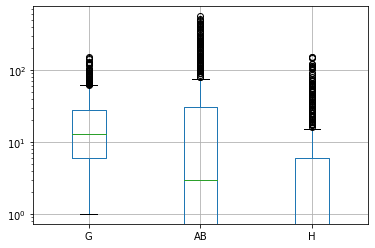

In [14]:
null_data = df[df.isnull().any(axis=1)]
display(null_data)

ax = null_data.boxplot(column=['G', 'AB','H'])
ax.set_yscale('log')

Based on the box 75% of the Players with no salary have played less that 75 games or has lastt than 75 at bats or 10 hits.  Although the rest may have significant playing time, we cannot imput the data since the salary of contracts must be manually inputted.  As a result of this project, we will remove the rows.  

#### Removing the rows with missing values

In [16]:
print("Number of Rows before removing:", len(df))
df_clean = df.dropna()
print("Total number of rows after removing the rows with missing values:",len(df_clean))

Number of Rows before removing: 1486
Total number of rows after removing the rows with missing values: 918


***
### [5 points] Are there other features that could be added to the data or created from existing features? Which ones?

#### For prediction purposes, we have categorized salary and grouped players salaries based on the salary range (Low - below 50%, Medium - 50%-75%, High-+75%, Elite)
> - Low (0-1,999,999)
> - Medium (2-5,999,999)
> - High (6,000,000 - 14,999,999)
> - Elite (+15,000,000)

In [18]:
df_clean['salary_cut'] = pd.cut(df_clean['salary'], bins = [0,1999999,5999999,14999999,50000000], labels=["Low", "Medium", "High", "Elite"], right=True)
df_clean.head()

C:\Datascience\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



playerID  yearID  stint teamID lgID    G   AB   R    H  2B  ...   CS  BB  \
1   abadfe01    2015      1    OAK   AL   62    0   0    0   0  ...  0.0   0   
2  abreujo02    2015      1    CHA   AL  154  613  88  178  34  ...  0.0  39   
4  ackledu01    2015      1    SEA   AL   85  186  22   40   8  ...  2.0  14   
5  ackledu01    2015      2    NYA   AL   23   52   6   15   3  ...  0.0   4   
7  adamsau01    2015      1    CLE   AL   28    1   0    0   0  ...  0.0   0   

      SO   IBB   HBP   SH   SF  GIDP     salary  salary_cut  
1    0.0   0.0   0.0  0.0  0.0   0.0  1087500.0         Low  
2  140.0  11.0  15.0  0.0  1.0  16.0  8666000.0        High  
4   38.0   0.0   1.0  3.0  3.0   3.0  2600000.0      Medium  
5    7.0   0.0   0.0  0.0  1.0   0.0  2600000.0      Medium  
7    0.0   0.0   0.0  0.0  0.0   1.0   507700.0         Low  

[5 rows x 24 columns]

#### Two other metrics can be derived from this 
> - On Base Percentage (OBP), quantity of getting on base per at bat
> - Slugging Percentage (SLG), quality of hits per at bat

In [35]:
#add new columns
df_clean["OBP"] = np.where((df_clean["AB"] +  df_clean["IBB"] + df_clean["BB"] + df_clean["HBP"] + df_clean["SF"]) !=0, 
                           (df_clean["H"] +  df_clean["IBB"] + df_clean["BB"] + df_clean["HBP"])/(df_clean["AB"] +  df_clean["IBB"] + df_clean["BB"] + df_clean["HBP"] + df_clean["SF"]),
                            0)
df_clean["SLG"] = np.where(df_clean["AB"] !=0,
                           (df_clean["H"] + df_clean["2B"]*2 + df_clean["3B"]*3 + df_clean["HR"]*4)/df_clean["AB"],
                           0)
df_clean.head()

C:\Datascience\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Datascience\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



playerID  yearID  stint teamID lgID    G   AB   R    H  2B  ...     SO  \
1   abadfe01    2015      1    OAK   AL   62    0   0    0   0  ...    0.0   
2  abreujo02    2015      1    CHA   AL  154  613  88  178  34  ...  140.0   
4  ackledu01    2015      1    SEA   AL   85  186  22   40   8  ...   38.0   
5  ackledu01    2015      2    NYA   AL   23   52   6   15   3  ...    7.0   
7  adamsau01    2015      1    CLE   AL   28    1   0    0   0  ...    0.0   

    IBB   HBP   SH   SF  GIDP     salary  salary_cut       OBP       SLG  
1   0.0   0.0  0.0  0.0   0.0  1087500.0         Low  0.000000  0.000000  
2  11.0  15.0  0.0  1.0  16.0  8666000.0        High  0.357879  0.611746  
4   0.0   1.0  3.0  3.0   3.0  2600000.0      Medium  0.269608  0.446237  
5   0.0   0.0  0.0  1.0   0.0  2600000.0      Medium  0.333333  0.826923  
7   0.0   0.0  0.0  0.0   1.0   507700.0         Low  0.000000  0.000000  

[5 rows x 26 columns]

***
### [15 points] Visualize the most important attributes appropriately (at least 5 attributes). Important: Provide an interpretation for each chart. Explain for each attribute why the chosen visualization is appropriate.

In [ ]:
## needs to be completed
#test 123

<AxesSubplot:xlabel='salary_cut', ylabel='salary'>

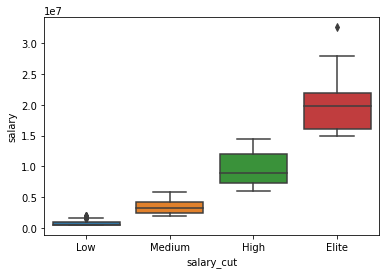

In [19]:
## salary ranges by salary cut
sns.boxplot(x="salary_cut", y="salary", data=df_clean)

***
### [15 points] Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

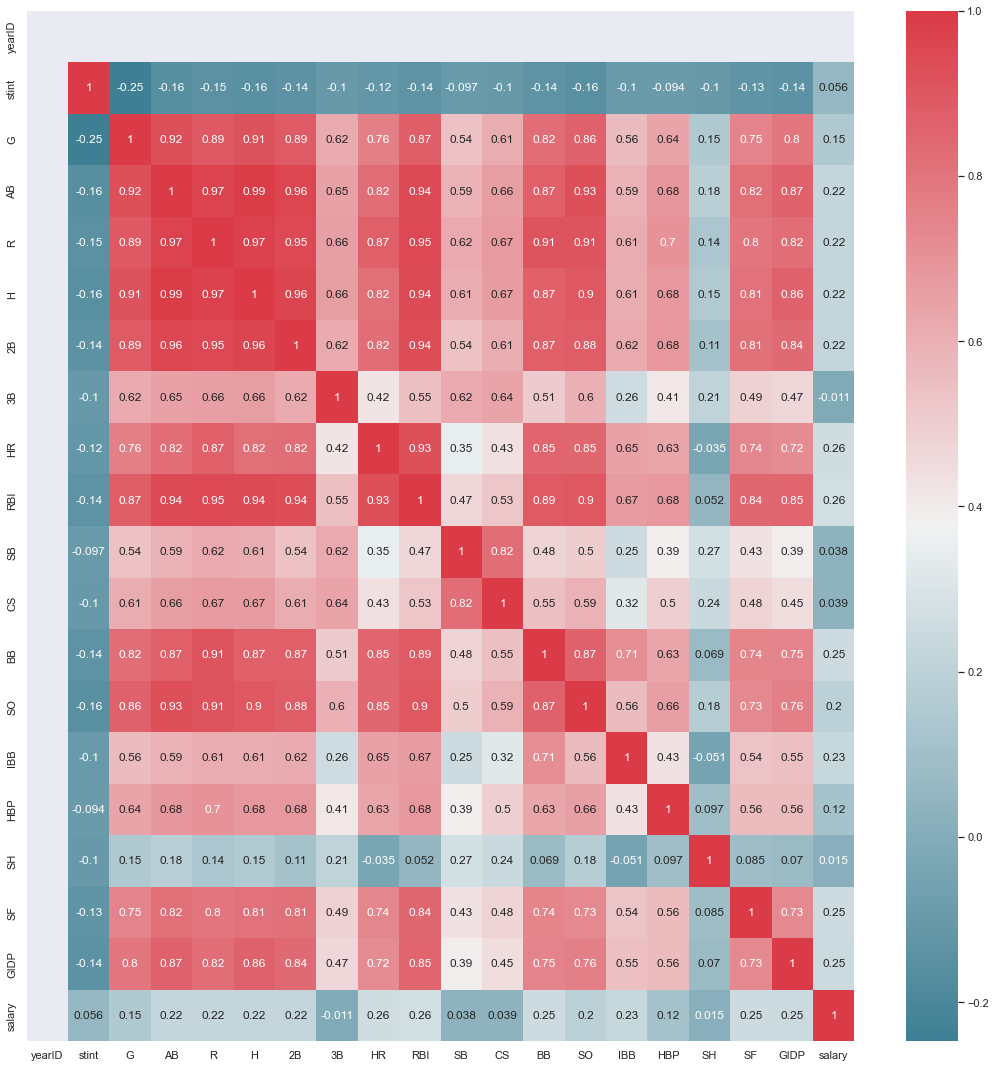

In [21]:
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_clean.corr(), cmap=cmap, annot=True)

f.tight_layout()

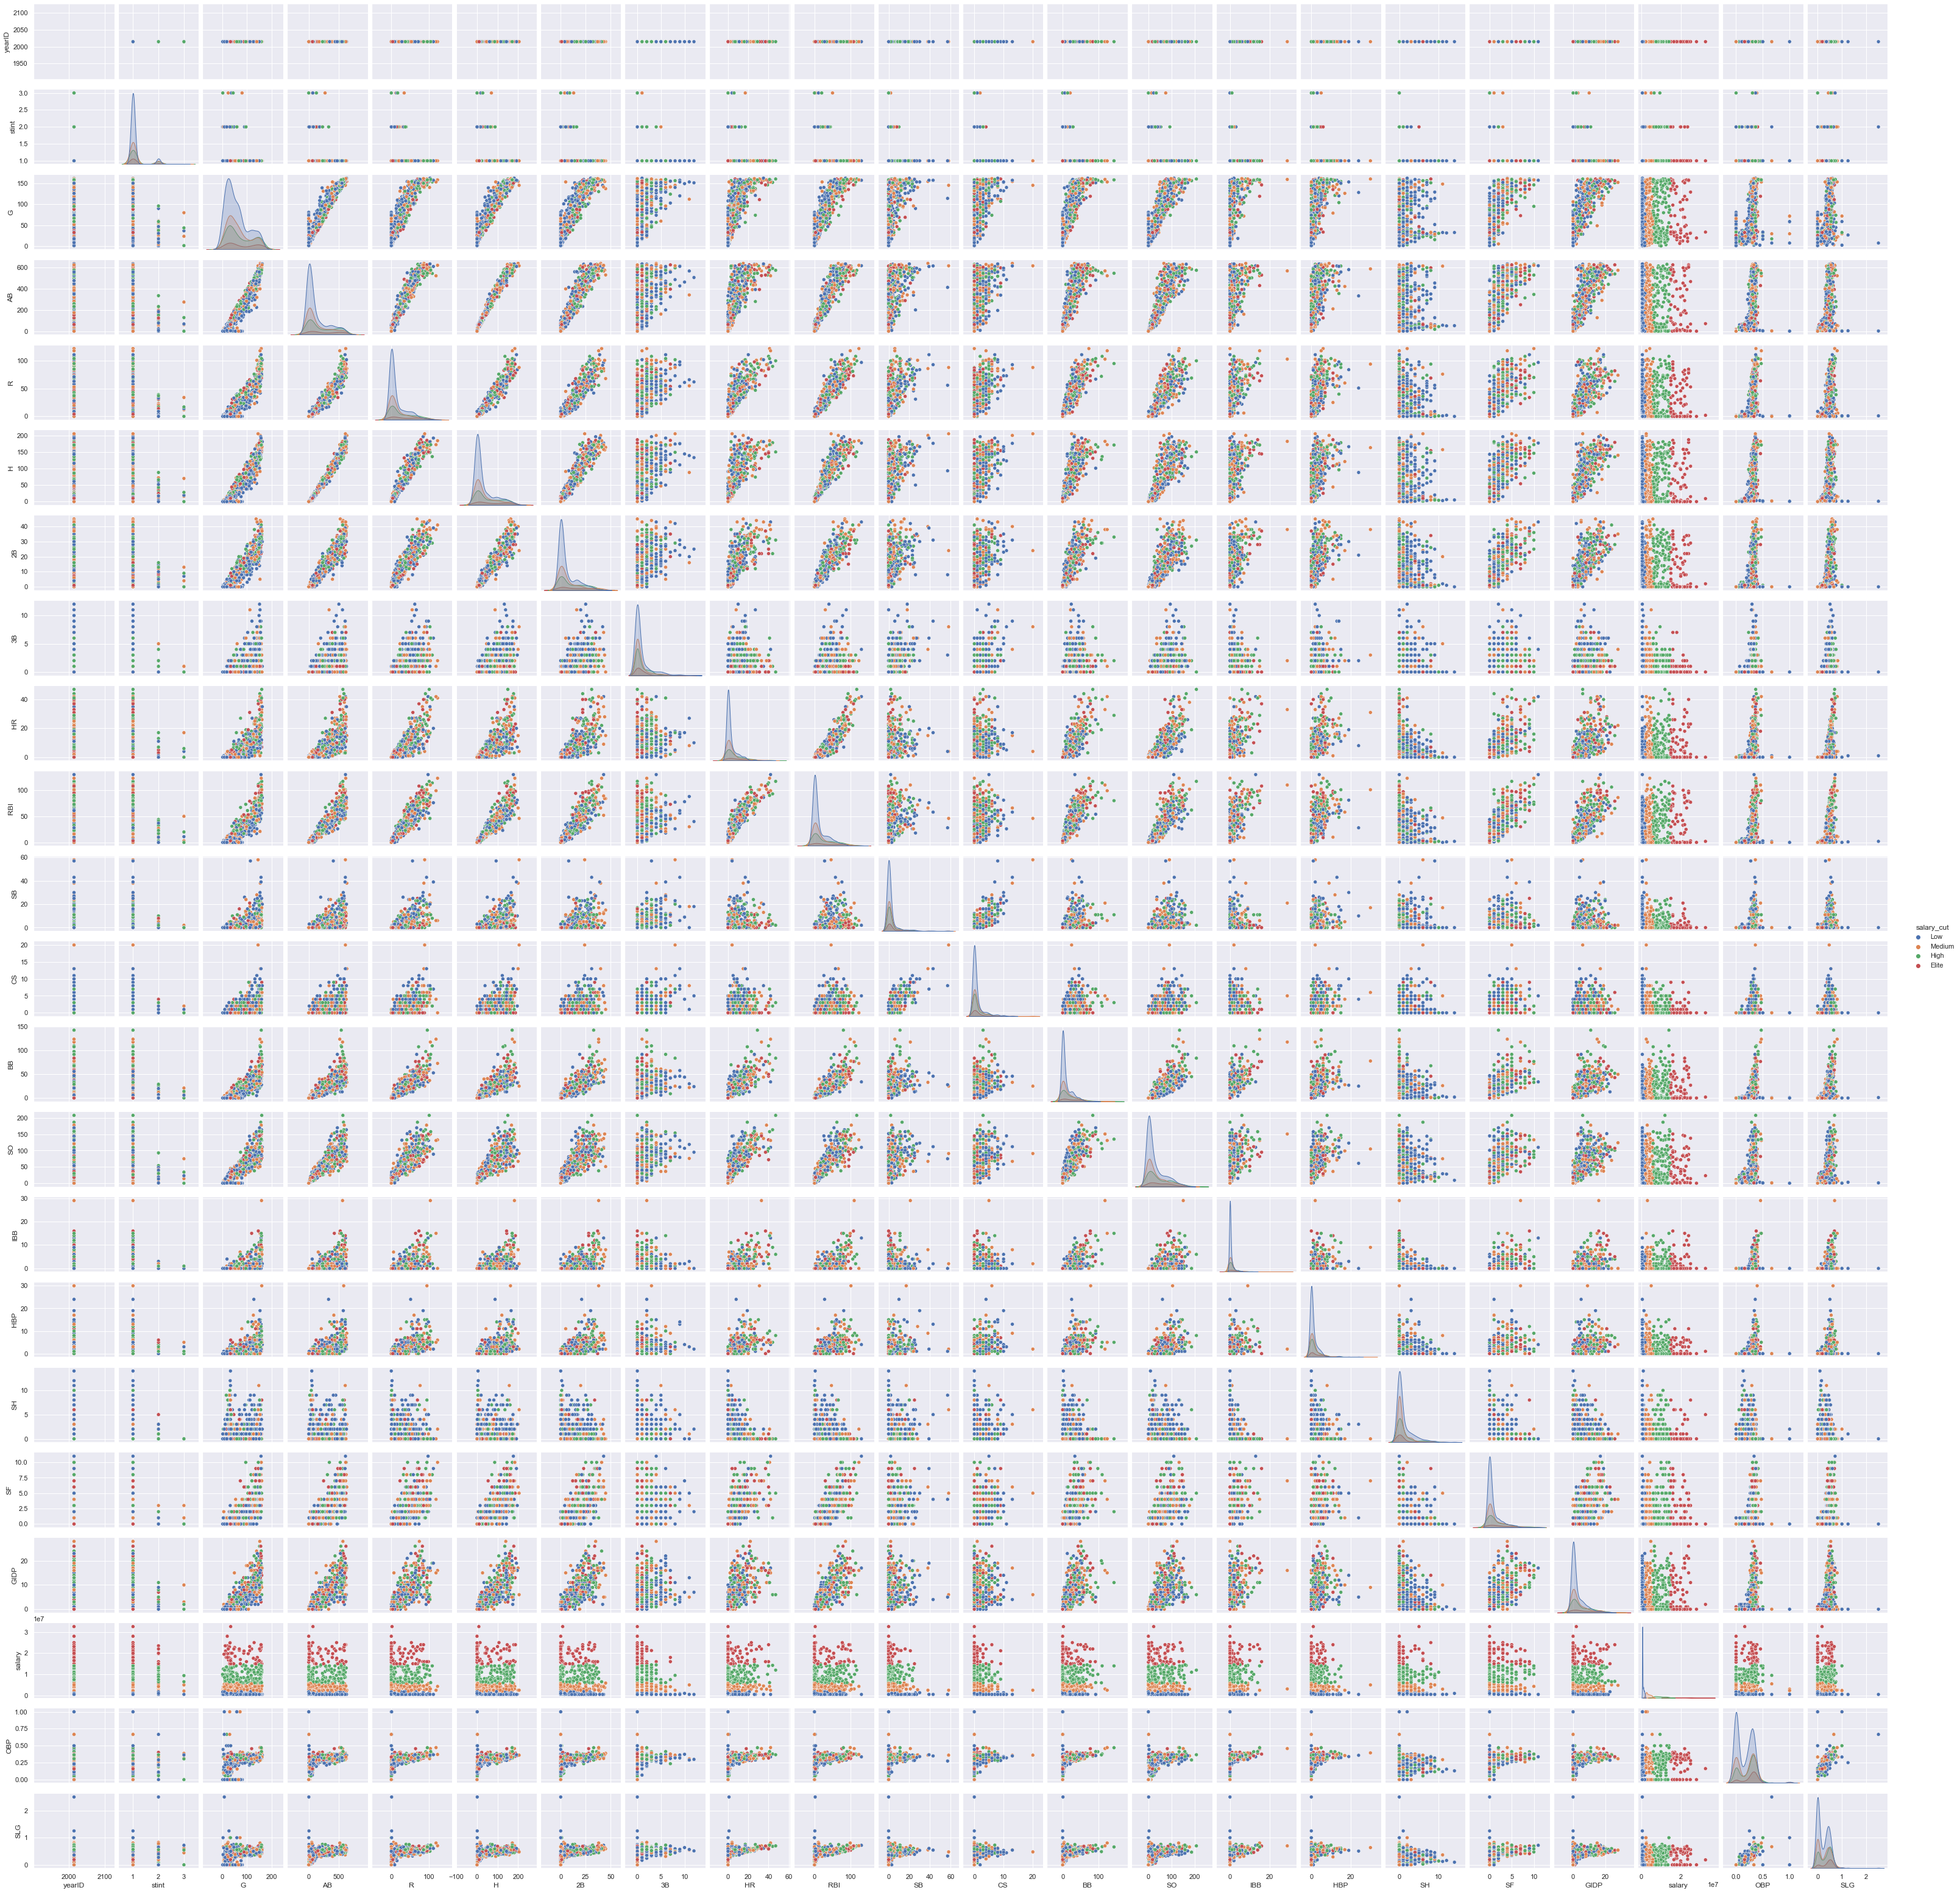

In [36]:
sns.pairplot(df_clean, hue="salary_cut", height=2)

***
### [10 points] Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

In [ ]:
## needs to be completed

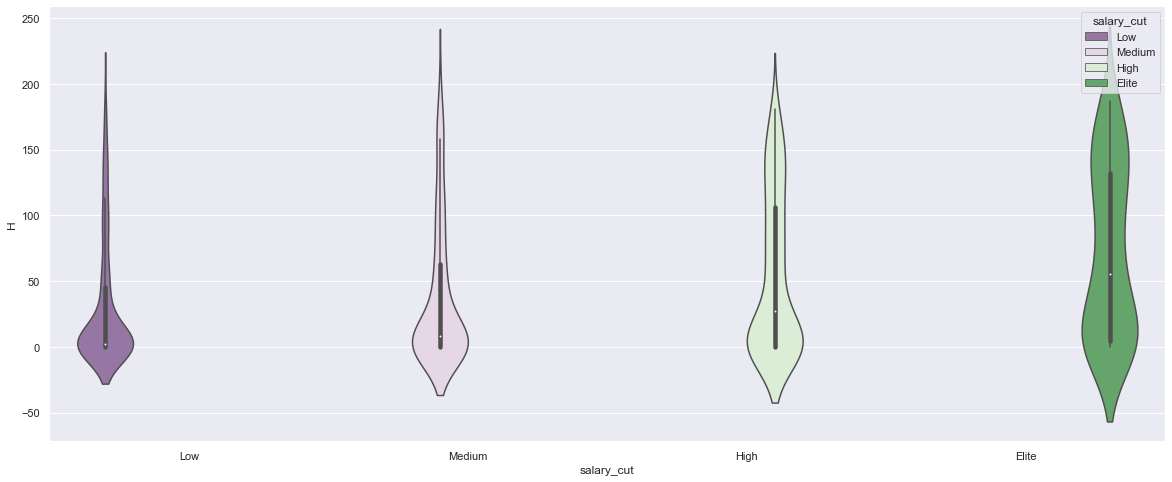

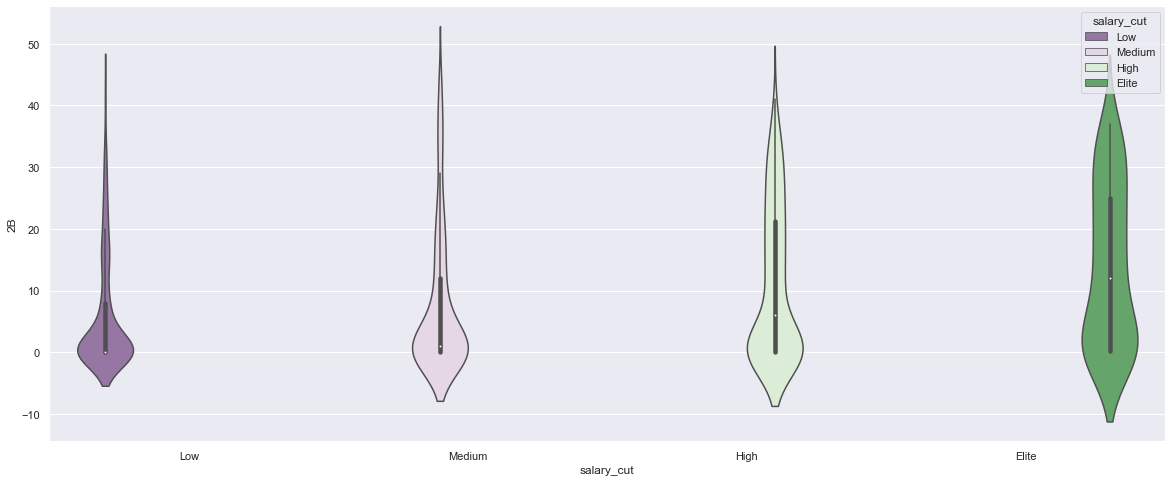

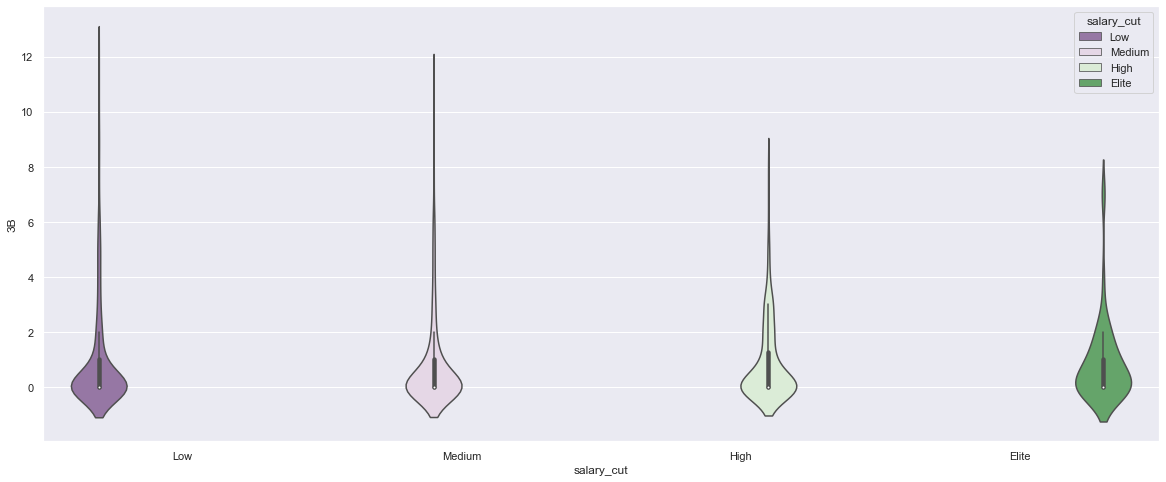

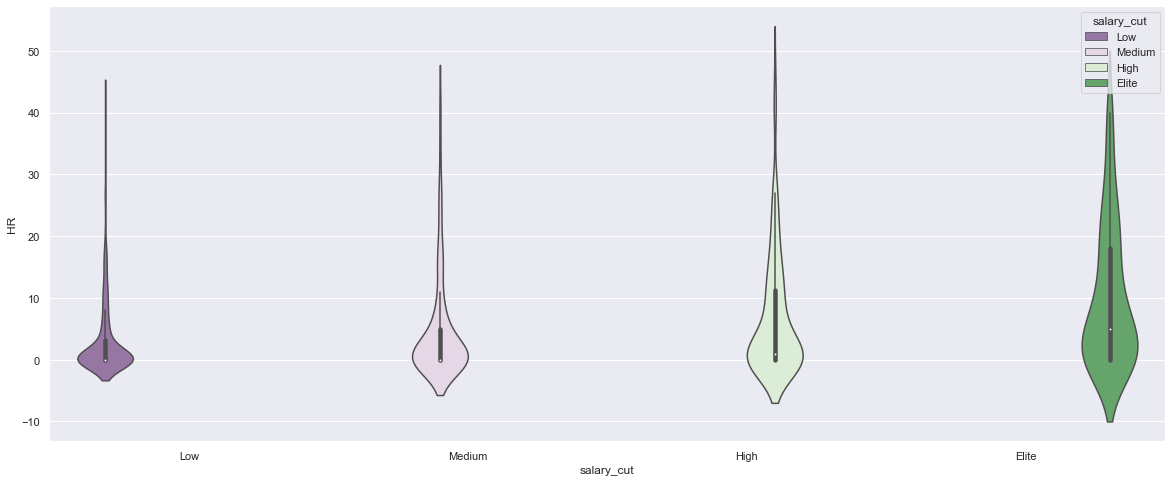

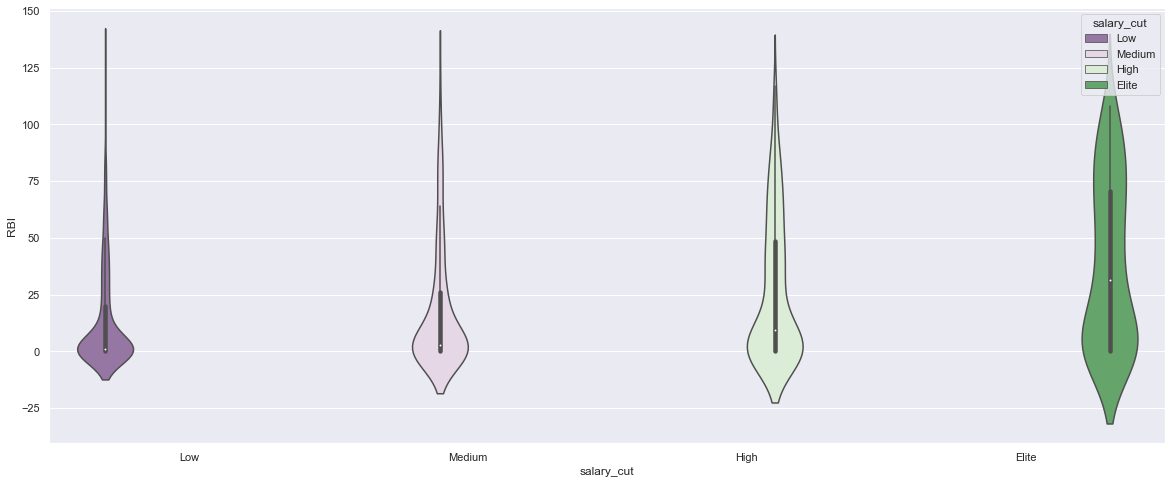

In [25]:
column = ['H', '2B', '3B', 'HR', 'RBI']
for col in column:
    plt.subplots(figsize=(20, 8))
    sns.violinplot(x="salary_cut", hue="salary_cut", y=col, data=df_clean,
            kind='violin', # other options: violin, bar, box, and others 
               palette='PRGn',
               height=7,ci=95)

***
### [10 points] Exceptional Work

In [ ]:
You have free reign to provide additional analyses.
One idea: implement dimensionality reduction, then visualize and interpret the results.

In [ ]:
# Use PCA from sklearn.decomposition
pca = PCA(n_components=2)
lda = LDA(n_components=2)
# Fit data and transform it
pca.fit(X)
X_pca = pca.transform(X)
X_lda = lda.fit(X, Y).transform(X)

In [ ]:
print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)